In [77]:
import numpy as np
import scipy as sp
from scipy import linalg
import matplotlib.pyplot as plt

In [78]:
# Defining an array that contains all nodes


# X_full = np.array([[5,  5,  0], 
#               [-5,  5,  0], 
#               [-5, -5,  0], 
#               [ 5, -5,  0], 
#               [2, 2, -3/2], 
#               [-2, 2, -3/2], 
#               [-2, -2, -3/2], 
#               [2, -2, -3/2]])

X_full = np.array([[5,  5,  0], 
              [-5,  5,  0], 
              [-5, -5,  0], 
              [ 5, -5,  0], 
              [1,1,1], 
              [1,1,1], 
              [1,1,1], 
              [1,1,1]])

X_fixed = np.array([[5,  5,  0], 
                   [-5,  5,  0], 
                   [-5, -5,  0], 
                   [ 5, -5,  0]])

X_free = np.array([
              [1,1,1], 
              [1,1,1], 
              [1,1,1], 
              [1,1,1]])

# X_free = np.array([
#               [2, 2, -3/2], 
#               [-2, 2, -3/2], 
#               [-2, -2, -3/2], 
#               [2, -2, -3/2]]
# )

X = np.reshape(X_full,(24))

X_fixed = np.reshape(X_fixed, (12))

X_free = np.reshape(X_free, (12))

free = [4,5,6,7]
fixed = [0,1,2,3]

e = { #Key value is the nodes conected with an edge, and the values are the lengths
    (1, 5) : 3,
    (2, 6) : 3,
    (3, 7) : 3,
    (4, 8) : 3,
    (5, 6) : 3,
    (5, 8) : 3,
    (6, 7) : 3,
    (7, 8) : 3,
}

k = 3 # Elasticity constant
l = 3 # Rest length
g = 10 # Gravitstional acceleration
m = { # Mass contribution of each node
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 1/60,
    5 : 1/60,
    6 : 1/60,
    7 : 1/60,
}

In [79]:
# Function that plots the nodes with their edges
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_nodes_edges(X_fixed, X_free, e):
    X_full = np.concatenate((X_fixed, X_free))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot fixed nodes in red
    ax.scatter(X_fixed[:,0], X_fixed[:,1], X_fixed[:,2], c='r')
    
    # Plot free nodes in blue
    ax.scatter(X_free[:,0], X_free[:,1], X_free[:,2], c='b')
    
    # Plot edges in black
    for edge in e:
        i, j = edge
        x = [X_full[i-1, 0], X_full[j-1, 0]]
        y = [X_full[i-1, 1], X_full[j-1, 1]]
        z = [X_full[i-1, 2], X_full[j-1, 2]]
        ax.plot(x, y, z, c='k')
    
    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Show plot
    plt.show()

Definging the energy funcitons and their gradients

In [80]:
# Define the elastic energy of a cable
def E_cable_elast(X, edge, k):
    X = np.reshape(X,(8,3))
    xi = X[edge[0]-1]
    xj = X[edge[1]-1]
    l = e[edge]
    if np.linalg.norm(xi - xj) > l:
        return k/(2*l**2) * (np.linalg.norm(xi-xj)-l)**2
    else:
        return 0

# Defining the external energy of a node
def E_ext(X, m, g):
    X = np.reshape(X,(8,3))
    e_ext = 0
    for i in range(len(X)):
        e_ext += X[i][2]*m[i]*g
    return e_ext

# Defining the total energy of the system
def E(X, e, k, m, g):
    X = np.reshape(X,(8,3))
    energy = 0
    for edge in e: #iterating through edges
        energy += E_cable_elast(X, edge, k)
    
    energy += E_ext(X, m, g)

    return energy

# Defining the gradient of E_cable_elast
def grad_E_cable_elast(X, edge, l, k):
    X = np.reshape(X,(8,3))
    xi = X[edge[0]-1]
    xj = X[edge[1]-1]
    l = e[edge]

    if np.linalg.norm(xi-xj) > l:
        return k/l**2*(1-l/np.linalg.norm(xi-xj))*(xi-xj)
    else:
        return np.zeros(3)
    
# Defining the gradient of E_ext
def grad_E_ext(i, m, g):
    return np.array([0,0,m[i]*g])

#Defining the gradient of E_tot
def grad_E(X,fixed, e, k, m, g):
    X = np.reshape(X,(8,3))
    # Initialize the gradient
    grad = np.zeros_like(X, dtype=float)
    
    # Calculate the gradient of the elastic energy of each cable
    for edge in e: #iterationg through edges
        i = edge[0]-1
        j = edge[1]-1
        if i not in fixed: # The fixed nodes should have zero gradiant
            grad[i] += grad_E_cable_elast(X, edge, l, k)
        grad[j] -= grad_E_cable_elast(X, edge, l, k) # The gradiant of the node connected to node i should be the negative of node i

    # Calculate the gradient of the external energy of each node
    for i in range(len(X)):
        grad[i] += grad_E_ext(i, m, g)

    # Removing the gradients of the fixed elements

    grad = np.delete(grad, fixed, axis=0)
    
    return np.reshape(grad, (12))

Deriving the BFGS Method

In [84]:
def StrongWolfe(E,grad_E,x,p,
                initial_value,
                initial_descent,
                initial_step_length = 1,
                c1 = 1e-2,
                c2 = 0.99,
                max_extrapolation_iterations = 50,
                max_interpolation_iterations = 20,
                rho = 2.0):
    '''
    Implementation of a bisection based bracketing method
    for the strong Wolfe conditions
    '''

    # initialise the bounds of the bracketing interval
    alphaR = initial_step_length
    alphaL = 0.0
    # Armijo condition and the two parts of the Wolfe condition
    # are implemented as Boolean variables
    next_x = x+alphaR*p
    next_value = E(np.concatenate((X_fixed, next_x)), e, k, m, g)
    next_grad = grad_E(np.concatenate((X_fixed, next_x)), fixed, e, k, m, g)
    Armijo = (next_value <= initial_value+c1*alphaR*initial_descent)
    descentR = np.inner(p,next_grad)
    curvatureLow = (descentR >= c2*initial_descent)
    curvatureHigh = (descentR <= -c2*initial_descent)
    # We start by increasing alphaR as long as Armijo and curvatureHigh hold,
    # but curvatureLow fails (that is, alphaR is definitely too small).
    # Note that curvatureHigh is automatically satisfied if curvatureLow fails.
    # Thus we only need to check whether Armijo holds and curvatureLow fails.
    itnr = 0
    while (itnr < max_extrapolation_iterations and (Armijo and (not curvatureLow))):
        itnr += 1
        # alphaR is a new lower bound for the step length
        # the old upper bound alphaR needs to be replaced with a larger step length
        alphaL = alphaR
        alphaR *= rho
        # update function value and gradient
        next_x = x+alphaR*p
        next_value = E(np.concatenate((X_fixed, next_x)), e, k, m, g)
        print(next_value)
        next_grad = grad_E(np.concatenate((X_fixed, next_x)), fixed, e, k, m, g)
        print(next_grad)
        # update the Armijo and Wolfe conditions
        Armijo = (next_value <= initial_value+c1*alphaR*initial_descent)
        descentR = np.inner(p,next_grad)
        curvatureLow = (descentR >= c2*initial_descent)
        curvatureHigh = (descentR <= -c2*initial_descent)
    # at that point we should have a situation where alphaL is too small
    # and alphaR is either satisfactory or too large
    # (Unless we have stopped because we used too many iterations. There
    # are at the moment no exceptions raised if this is the case.)
    alpha = alphaR
    grad_evals = itnr+1
    itnr = 0
    # Use bisection in order to find a step length alpha that satisfies
    # all conditions.
    while (itnr < max_interpolation_iterations and (not (Armijo and curvatureLow and curvatureHigh))):
        itnr += 1
        if (Armijo and (not curvatureLow)):
            # the step length alpha was still too small
            # replace the former lower bound with alpha
            alphaL = alpha
        else:
            # the step length alpha was too large
            # replace the upper bound with alpha
            alphaR = alpha
        # choose a new step length as the mean of the new bounds
        alpha = (alphaL+alphaR)/2
        # update function value and gradient
        next_x = x+alphaR*p
        next_value = E(np.concatenate((X_fixed, next_x)), e, k, m, g)
        next_grad = grad_E(np.concatenate((X_fixed, next_x)), fixed, e, k, m, g)
        # update the Armijo and Wolfe conditions
        Armijo = (next_value <= initial_value+c1*alphaR*initial_descent)
        descentR = np.inner(p,next_grad)
        curvatureLow = (descentR >= c2*initial_descent)
        curvatureHigh = (descentR <= -c2*initial_descent)
    # return the next iterate as well as the function value and gradient there
    # (in order to save time in the outer iteration; we have had to do these
    # computations anyway)
    grad_evals += itnr
    return next_x,next_value,next_grad,grad_evals

In [82]:
def BFGS(E,grad_E,x_init,
          max_steps = 2000,
          gradient_stop = 1e-6):
    '''
    Implementation of the BFGS method.
    '''
    # Initialise the variable x
    x = x_init
    # Initialise the quasi-Newton matrix as the identity
    H = np.eye(len(x))
    # Main loop
    n_step = 0
    current_value = E(np.concatenate((X_fixed, x)), e, k, m, g)
    current_gradient = grad_E(np.concatenate((X_fixed, x)), fixed, e, k, m, g)
    # count the number of gradient evaluations
    total_grad_evals = 1
    norm_grad = np.linalg.norm(current_gradient)
    while ((n_step < max_steps) and (norm_grad > gradient_stop)):
        n_step += 1
        search_direction = -H@current_gradient
        descent = np.inner(search_direction,current_gradient)
        x_old = x
        gradient_old = current_gradient
        x,current_value,current_gradient,grad_evals = StrongWolfe(E,grad_E,x,
                                                                  search_direction,
                                                                  current_value,descent)
        total_grad_evals += grad_evals
        norm_grad = np.linalg.norm(current_gradient)
        s = x - x_old
        y = current_gradient - gradient_old
        rho = 1/np.inner(y,s)
        if n_step==1:
            H = H*(1/(rho*np.inner(y,y)))
        z = H.dot(y)
        H += -rho*(np.outer(s,z) + np.outer(z,s)) + rho*(rho*np.inner(y,z)+1)*np.outer(s,s)
    return np.round(np.reshape(x,(4,3)),5)

Plotting the nodes with their edges for problem 5

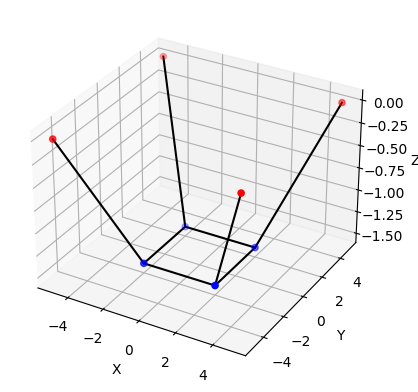

In [83]:
X_free = BFGS(E,grad_E,X_free,max_steps = 1000,gradient_stop = 1e-6)
X_fixed = np.reshape(X_fixed, (4,3))

plot_nodes_edges(X_fixed, X_free, e)